El dataset utilizado consta de 27.000 imágenes RGB de 64×64 bits del Sentinel 2, clasificadas en 10 categorías de diferentes de usos o tipos de suelo. La tarea que queremos que aprenda la CNN que entrenemos es que consiga predecir el uso de un suelo a partir de la imagen de este. Puedes descargarlo en el siguiente enlace, en el apartado ‘Datasets for Machine Learning’, buscando el enlace a ’EuroSAT (RGB color space images)’:



http://madm.dfki.de/downloads

In [61]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
path_dataset = '../output/input_model/'

dic_class = {}
datos_entrada =[]
clases_salida=[]
i=0

for element in os.listdir(path_dataset):
    if os.path.isdir(path_dataset+element):
        for file in os.listdir(path_dataset+element):
            im = Image.open(os.path.join(path_dataset, element, file))
            im_array = np.array(im)
            datos_entrada.append(im_array)
            clases_salida.append(i)
        dic_class[i] = element
        i+=1

La forma de representar las clases en Keras es mediante la codificación ‘one hot’: la clase de cada imagen se representa por un vector en el que cada posición se corresponde con una de las posibles clases que pueden darse, en el que todos sus elementos son cero excepto el que se corresponde con la clase a la que pertenece la imagen. Para crear la codificación one hot podemos usar la siguiente función:



In [63]:
clases_salida_oh = to_categorical(clases_salida) #One hot encode

Además es conveniente normalizar las imágenes de modo que el rango de entrada a la CNN se encuentren entre 0 y 1:

In [64]:
datos_entrada = np.array(datos_entrada)/255


Por otra nos aseguraremos de ordenar los datos de forma aleatoria con shuffle=True:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(datos_entrada, clases_salida_oh, test_size=0.33, shuffle=True)

A continuación creamos nuestro clasificador mediante un modelo ‘Sequential’, este es el modo más sencillo para crear redes neuronales con Keras. Para definir el modelo se pasa una lista donde se indican secuencialmente las capas que formarán dicho modelo.

En esta entrada no se explicará en detalle en qué consiste cada capa ni cómo procesan la información. No obstante cabe mencionar varios detalles:

* En la primera capa se indica el tamaño de entrada (almacenado en la variable in_shape mediante el método shape en nuestro código).
* Para cada capa de neuronas se define su tamaño. Para las capas convolucionales (Conv2D) se establece el número de filtros y el tamaño de la matriz que realiza cada convolución. Para las capas totalmente conectadas (Dense), se establece el número de neuronas de la capa.
* Un elemento importante de las neuronas es la función de activación, en las CNN se suele utilizar la función ‘relu’.
* La capa de salida debe tener tantas neuronas como clases, y su función de activación ser la función ‘softmax’. Esta función fuerza a que la suma de todas las neuronas de salida sea 1, gracias a ello se puede interpretar cada salida como la probabilidad de que la entrada pertenezca a la clase asociada a dicha salida.

In [66]:
in_shape = X_train[0,:,:,:].shape

In [67]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=in_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(50))
model.add(Dense(len(dic_class),activation='softmax'))

Una vez creado el modelo, este se compila. Aquí se elige el algoritmo que se usará para entrenarlo (‘adam’); la función de pérdida, que para problemas de clasificación normalmente utilizada es entropía cruzada categórica (‘categorical_crossentropy’) y la métrica para evaluar su rendimiento, en nuestro caso la exactitud (‘accuracy’).

In [68]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [78]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=14)

Epoch 1/14
566/566 [==============================] - 31s 54ms/step - loss: 0.2080 - accuracy: 0.9273 - val_loss: 0.7257 - val_accuracy: 0.8013
Epoch 2/14
566/566 [==============================] - 29s 52ms/step - loss: 0.1866 - accuracy: 0.9357 - val_loss: 0.7165 - val_accuracy: 0.8058
Epoch 3/14
566/566 [==============================] - 29s 51ms/step - loss: 0.1609 - accuracy: 0.9448 - val_loss: 0.8160 - val_accuracy: 0.7909
Epoch 4/14
566/566 [==============================] - 29s 52ms/step - loss: 0.1475 - accuracy: 0.9486 - val_loss: 0.8982 - val_accuracy: 0.7896
Epoch 5/14
566/566 [==============================] - 29s 51ms/step - loss: 0.1397 - accuracy: 0.9522 - val_loss: 0.9736 - val_accuracy: 0.7811
Epoch 6/14
566/566 [==============================] - 33s 58ms/step - loss: 0.1200 - accuracy: 0.9600 - val_loss: 0.9219 - val_accuracy: 0.7985
Epoch 7/14
566/566 [==============================] - 34s 60ms/step - loss: 0.1354 - accuracy: 0.9536 - val_loss: 0.8869 - val_accuracy:

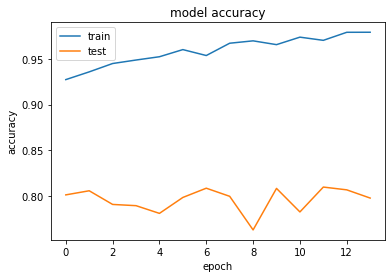

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

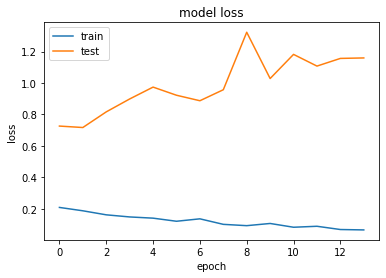

In [81]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
prob_pred_test = model.predict(X_test)

In [71]:
predicciones_test = [dic_class[np.argmax(prob)] for prob in prob_pred_test]
clases_test = [dic_class[np.argmax(clas)] for clas in y_test]

In [72]:
clases_test[:10] #clases verdaderas

['PermanentCrop',
 'SeaLake',
 'SeaLake',
 'Forest',
 'Pasture',
 'Residential',
 'AnnualCrop',
 'Pasture',
 'AnnualCrop',
 'HerbaceousVegetation']

In [73]:
predicciones_test[:10] #predicciones

['PermanentCrop',
 'SeaLake',
 'SeaLake',
 'Forest',
 'Pasture',
 'Residential',
 'AnnualCrop',
 'Pasture',
 'AnnualCrop',
 'HerbaceousVegetation']

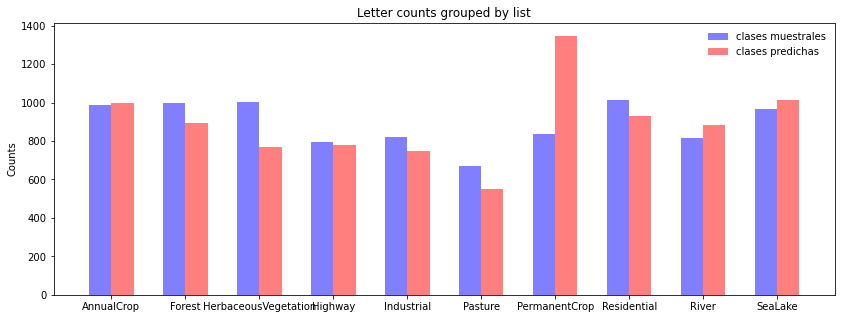

In [74]:
# Create dictionaries from lists with this format: 'letter':count
dict1 = dict(zip(*np.unique(clases_test, return_counts=True)))
dict2 = dict(zip(*np.unique(predicciones_test, return_counts=True)))

# Add missing letters with count=0 to each dictionary so that keys in
# each dictionary are identical
only_in_set1 = set(dict1)-set(dict2)
only_in_set2 = set(dict2)-set(dict1)
dict1.update(dict(zip(only_in_set2, [0]*len(only_in_set2))))
dict2.update(dict(zip(only_in_set1, [0]*len(only_in_set1))))

# Sort dictionaries alphabetically
dict1 = dict(sorted(dict1.items()))
dict2 = dict(sorted(dict2.items()))

# Create grouped bar chart
xticks = np.arange(len(dict1))
bar_width = 0.3
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(xticks-bar_width/2, dict1.values(), bar_width,
       color='blue', alpha=0.5, label='clases muestrales')
ax.bar(xticks+bar_width/2, dict2.values(), bar_width,
       color='red', alpha=0.5, label='clases predichas')

# Set annotations, x-axis ticks and tick labels
ax.set_ylabel('Counts')
ax.set_title('Letter counts grouped by list')
ax.set_xticks(xticks)
ax.set_xticklabels(dict1.keys())
ax.legend(frameon=False)
plt.show()